# ITU ICT Indicators Analysis
Exploratory analysis of ICT access, usage and affordability using ITU official data


## 1. Environment Setup
Import required libraries and configure visual settings

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid")

# Set a fixed project root directory
project_root = r"C:\Users\Den\PyCharmMiscProject"

# Define paths for outputs and figures
outputs_dir = os.path.join(project_root, "outputs")
figures_dir = os.path.join(outputs_dir, "figures")

# Create directories if they do not exist
os.makedirs(figures_dir, exist_ok=True)

# Print paths for confirmation
print("Project root:", project_root)
print("Outputs directory:", outputs_dir)
print("Figures directory:", figures_dir)

Project root: C:\Users\Den\PyCharmMiscProject
Outputs directory: C:\Users\Den\PyCharmMiscProject\outputs
Figures directory: C:\Users\Den\PyCharmMiscProject\outputs\figures


## 2. Load Data
Load all CSV files from the `src` folder into a dictionary

In [12]:
raw_data_dir = os.path.join(project_root, "src")

# Dictionary to store all dataframes
data_dict = {}

for file in os.listdir(raw_data_dir):
    if file.endswith(".csv"):
        file_path = os.path.join(raw_data_dir, file)
        df_name = file.replace(".csv", "")
        data_dict[df_name] = pd.read_csv(
            file_path,
            sep=',',
            encoding='utf-8',
            on_bad_lines='skip'
        )
        print(f"Loaded {file} with shape {data_dict[df_name].shape}")

Loaded active_mobile_broadband_subscriptions.csv with shape (6271, 13)
Loaded data_only_mobile_broadband_basket_5gb.csv with shape (1861, 13)
Loaded fixed_broadband_price_5gb.csv with shape (4568, 13)
Loaded fixed_broadband_subscriptions.csv with shape (8844, 13)
Loaded households_internet_access.csv with shape (3964, 13)
Loaded household_ict_expenditure.csv with shape (73, 13)
Loaded individuals_using_internet.csv with shape (4943, 13)
Loaded mobile_phone_ownership.csv with shape (1109, 13)
Loaded population_coverage_mobile_network.csv with shape (9609, 13)
Loaded smartphone_ownership.csv with shape (125, 13)


## 3. Inspect Data

Check structure, missing values and columns of each dataframe.

In [13]:
for name, df in data_dict.items():
    print(f"=== {name} ===")
    print(df.info())
    print(df.isnull().sum())
    print("-" * 50)

=== active_mobile_broadband_subscriptions ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6271 entries, 0 to 6270
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seriesID           6271 non-null   int64  
 1   seriesCode         6271 non-null   object 
 2   seriesName         6271 non-null   object 
 3   seriesParent       0 non-null      float64
 4   seriesUnits        6271 non-null   object 
 5   entityID           6271 non-null   int64  
 6   entityIso          6271 non-null   object 
 7   entityName         6271 non-null   object 
 8   dataValue          6271 non-null   float64
 9   dataYear           6271 non-null   int64  
 10  dataNote           770 non-null    object 
 11  dataSource         3078 non-null   object 
 12  seriesDescription  6271 non-null   object 
dtypes: float64(2), int64(3), object(8)
memory usage: 637.0+ KB
None
seriesID                0
seriesCode              0
series

## 4. Time-Series: Households with Internet Access
Plot top 10 countries by latest data

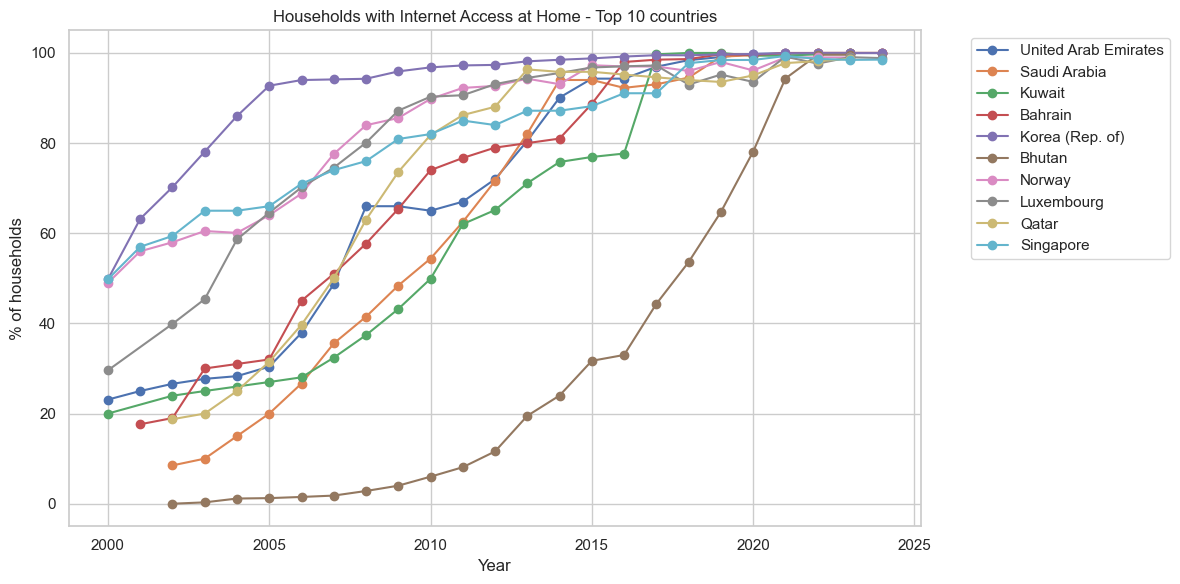

In [14]:
df = data_dict['households_internet_access']

# Select top 10 countries by latest data
latest = df.sort_values('dataYear').groupby('entityName').tail(1)
top_countries = latest.sort_values('dataValue', ascending=False).head(10)['entityName'].tolist()

plt.figure(figsize=(12, 6))
for country in top_countries:
    country_data = df[df['entityName'] == country]
    plt.plot(country_data['dataYear'], country_data['dataValue'], marker='o', label=country)

plt.title("Households with Internet Access at Home - Top 10 countries")
plt.xlabel("Year")
plt.ylabel("% of households")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "households_internet_access_timeseries.png"), dpi=300)
plt.show()

## 5. Scatter Plot: Households vs Individuals using Internet

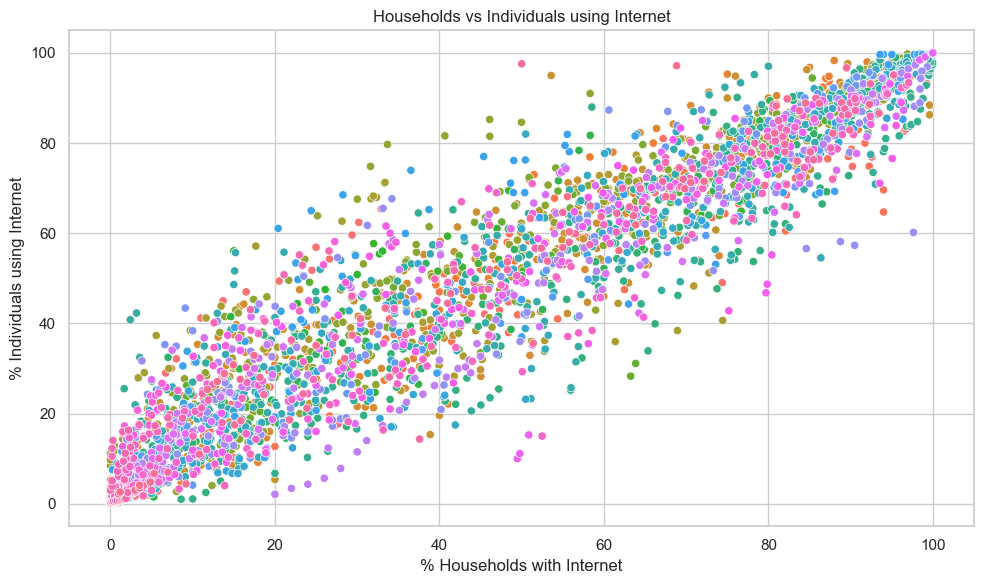

In [15]:
df1 = data_dict['households_internet_access']
df2 = data_dict['individuals_using_internet']

merged_df = pd.merge(df1, df2, on=['entityName', 'dataYear'], suffixes=('_household', '_individual'))

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='dataValue_household', y='dataValue_individual', hue='entityName', legend=False)
plt.title("Households vs Individuals using Internet")
plt.xlabel("% Households with Internet")
plt.ylabel("% Individuals using Internet")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "households_vs_individuals.png"), dpi=300)
plt.show()

## 6. Country-specific line chart (Ukraine example)

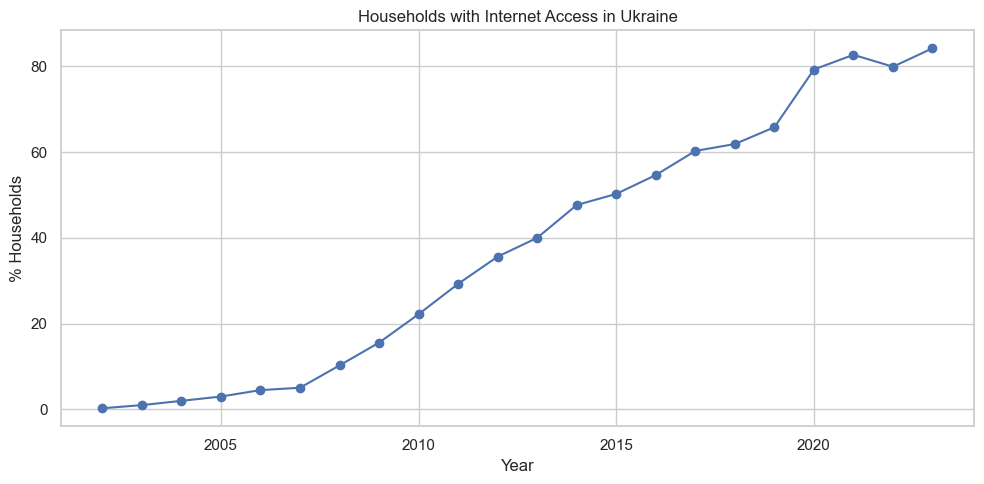

In [16]:
df = data_dict['households_internet_access']

country = "Ukraine"
country_data = df[df['entityName'] == country]

plt.figure(figsize=(10, 5))
plt.plot(country_data['dataYear'], country_data['dataValue'], marker='o', linestyle='-')
plt.title(f"Households with Internet Access in {country}")
plt.xlabel("Year")
plt.ylabel("% Households")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, f"households_internet_access_{country.lower()}.png"), dpi=300)
plt.show()

## 7. Internet Affordability vs Household Access

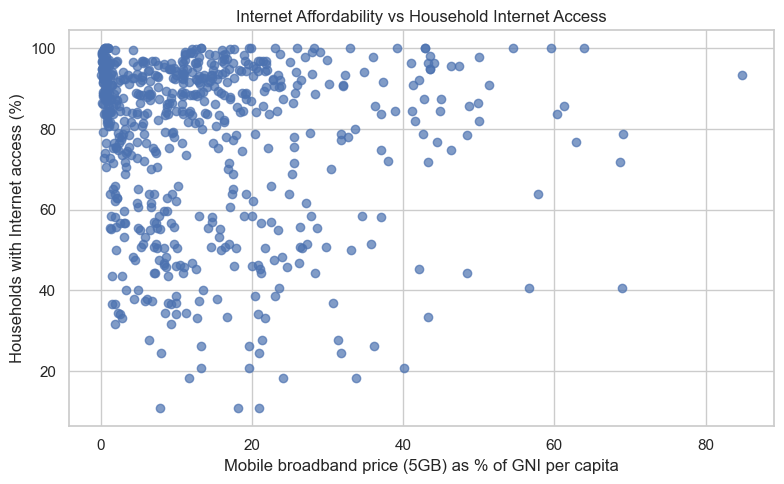

In [17]:
access = data_dict['households_internet_access'].copy()
price = data_dict['data_only_mobile_broadband_basket_5gb'].copy()

for df_tmp in [access, price]:
    df_tmp['dataYear'] = pd.to_numeric(df_tmp['dataYear'], errors='coerce')
    df_tmp['dataValue'] = pd.to_numeric(df_tmp['dataValue'], errors='coerce')

access = access[['entityName', 'dataYear', 'dataValue']].rename(columns={'dataValue': 'internet_access_pct'})
price = price[['entityName', 'dataYear', 'dataValue']].rename(columns={'dataValue': 'price_pct_gni'})

merged = pd.merge(access, price, on=['entityName', 'dataYear'], how='inner')

plt.figure(figsize=(8, 5))
plt.scatter(merged['price_pct_gni'], merged['internet_access_pct'], alpha=0.7)
plt.xlabel('Mobile broadband price (5GB) as % of GNI per capita')
plt.ylabel('Households with Internet access (%)')
plt.title('Internet Affordability vs Household Internet Access')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "internet_affordability_vs_access.png"), dpi=300)
plt.show()

## 8. Top & Bottom 10 Countries by Internet Usage

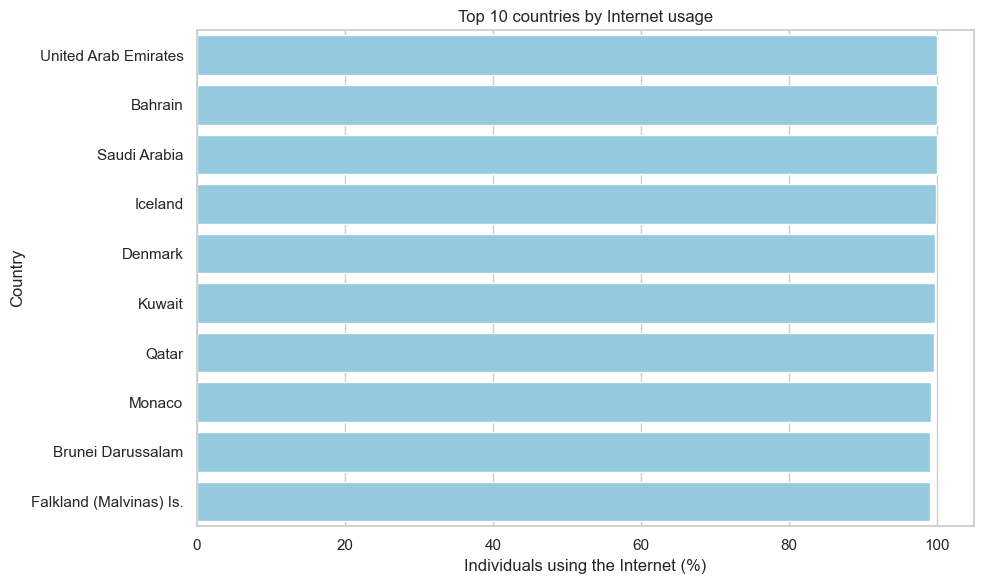

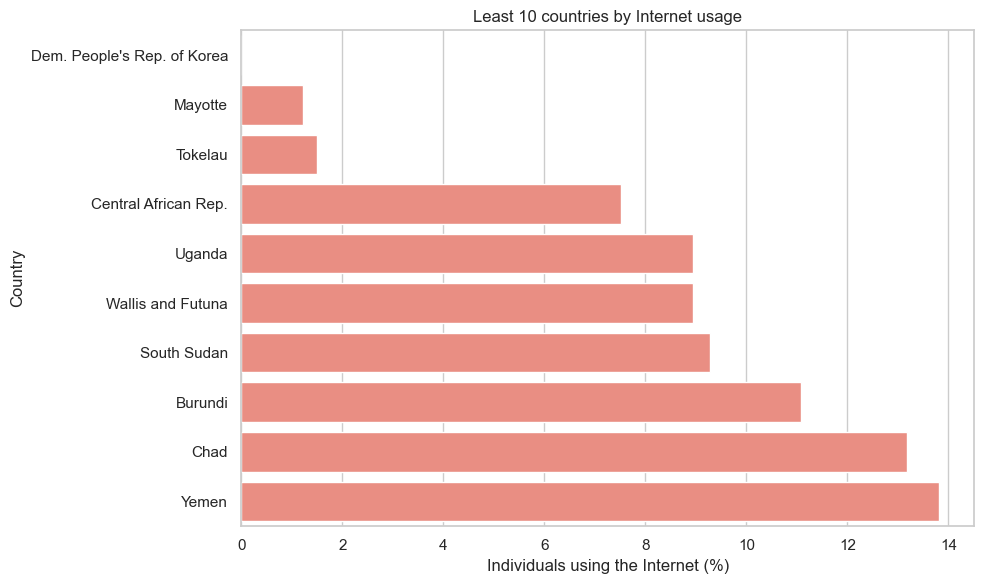

In [18]:
df_internet = data_dict['individuals_using_internet']

# Get latest data for each country
latest_internet = df_internet.sort_values('dataYear').groupby('entityName').tail(1)
latest_internet = latest_internet[['entityName', 'dataValue']]

# Top 10
top_10 = latest_internet.sort_values('dataValue', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10, x='dataValue', y='entityName', color='skyblue')
plt.xlabel('Individuals using the Internet (%)')
plt.ylabel('Country')
plt.title('Top 10 countries by Internet usage')
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "top_10_internet_usage.png"), dpi=300)
plt.show()

# Bottom 10
bottom_10 = latest_internet.sort_values('dataValue', ascending=True).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(data=bottom_10, x='dataValue', y='entityName', color='salmon')
plt.xlabel('Individuals using the Internet (%)')
plt.ylabel('Country')
plt.title('Least 10 countries by Internet usage')
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "least_10_internet_usage.png"), dpi=300)
plt.show()